In [1]:
def process_tweets(df):
    import pandas as pd
    import re
    from copy import copy
    from nltk.corpus import stopwords
    from nltk.util import bigrams, trigrams
    from numpy import where
    stop_words=stopwords.words("english")
    
    df=df.drop(["source"], axis=1)
    df.insert(loc=5, column="is_retweet_fix", value=[True if re.search(pattern="RT",string=i) else False for i in df.text])

    df=df[df.is_retweet_fix==False]
    df.insert(loc=2, column="date", value=pd.to_datetime(df.created_at).dt.strftime("%Y-%m-%d"))
    
    df=df.drop(["created_at", "id_str", "is_retweet", "is_retweet_fix"], axis=1)
    df["text"]=[re.sub(".@"," @",i) for i in df.text]
    df=df.sort_values(by=["date"], ascending=True).reset_index(drop=True)
    

    return df


In [2]:
import pandas as pd
from collections import defaultdict, deque
import os
import copy
import numpy as np
import itertools as it
from pathlib import Path


import matplotlib.pyplot as plt

In [4]:
df_dict=defaultdict()
df_dict.default_factory=pd.DataFrame

for a_file in os.listdir(path_to_files):
    print(f"reading {a_file}")
    the_tweets=pd.read_json(Path.joinpath(path_to_files, f"{a_file}"))
    df_dict[str(a_file.split(".")[0])]=process_tweets(the_tweets)



reading 2009.json
reading 2010.json
reading 2011.json
reading 2012.json
reading 2013.json
reading 2014.json
reading 2015.json
reading 2016.json
reading 2017.json
reading 2018.json
reading 2019.json
reading 2020.json


In [5]:
full_table = pd.concat([df_dict["2009"],df_dict["2010"],df_dict["2011"],df_dict["2012"],df_dict["2013"],df_dict["2014"],df_dict["2015"],df_dict["2016"],df_dict["2017"],df_dict["2018"],df_dict["2019"],df_dict["2020"]], axis=0).reset_index(drop=True)

In [6]:
date_col = pd.DataFrame(pd.date_range(start=full_table.date.min(), end=full_table.date.max(), freq="D"), columns=["date"])
date_col.date = [str(i).split(" ")[0] for i in date_col.date]

In [7]:
twtbl=date_col.merge(full_table, how="left")

In [8]:
twtbl.retweet_count=[0 if np.isnan(i) else i for i in twtbl.retweet_count]
twtbl.favorite_count=[0 if np.isnan(i) else i for i in twtbl.favorite_count]
twtbl.text=["" if pd.isnull(i) else i for i in twtbl.text]

In [10]:
twtbl.shape

(34481, 4)

In [15]:
twtbl.to_parquet(Path.joinpath(cwd.parent, "processed", "tweet_counts.parquet"),index=False)

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;



In [13]:
interem=copy.copy(twtbl[["date","retweet_count","favorite_count"]])

In [27]:
grouped=interem.groupby("date").agg({"retweet_count":np.sum, "favorite_count":np.sum}).reset_index(drop=False)

In [34]:
np.where(grouped.date == '2019-01-01')

(array([3529]),)

In [22]:
import matplotlib.pyplot as plt

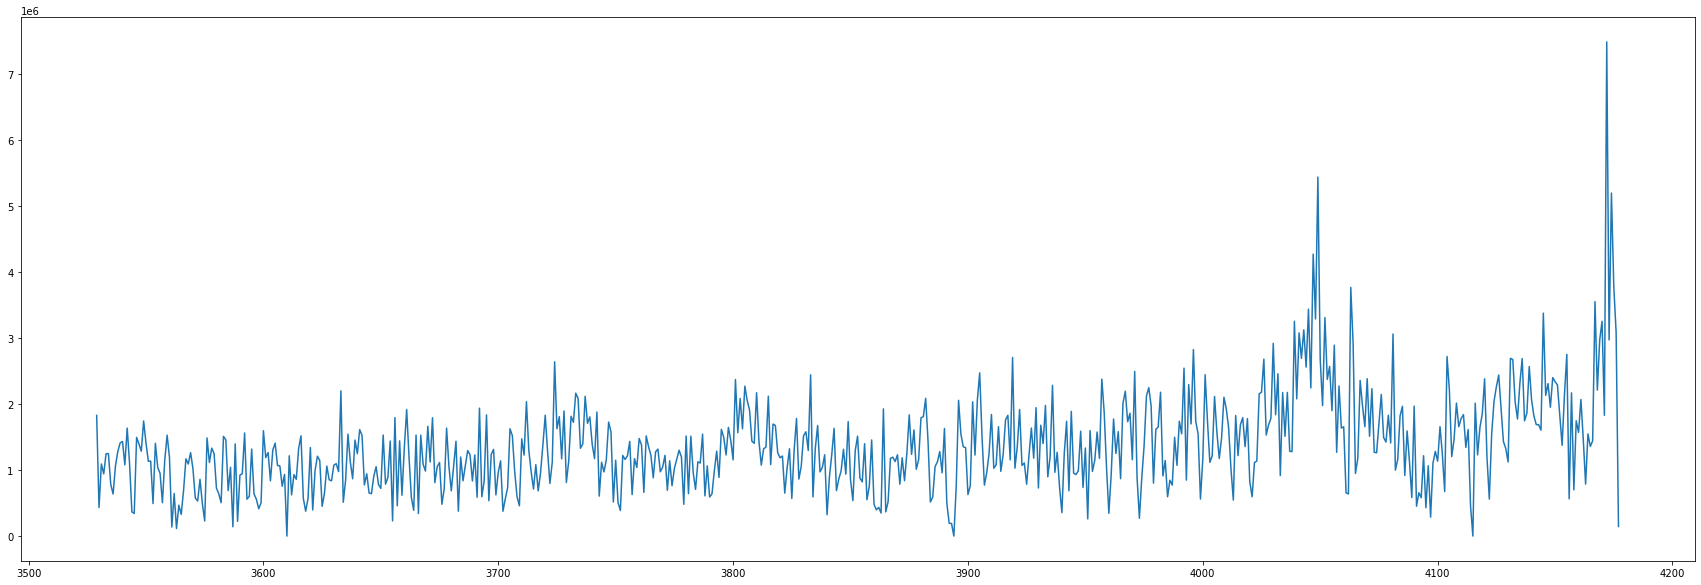

In [35]:
plt.figure(figsize=(30,10))
_=plt.plot(grouped.favorite_count[3529:])


In [ ]:
    #df.insert(loc=2, column="year_c", value=pd.to_datetime(df.created_at).dt.year)
    #df.insert(loc=2, column="month_c", value=pd.to_datetime(df.created_at).dt.month)
    #df.insert(loc=2, column="day_c", value=pd.to_datetime(df.created_at).dt.day)
    #df.insert(loc=2, column="time", value=pd.to_datetime(df.created_at).dt.strftime("%H:%M"))    
    
    df.insert(loc=0, column="text_1", value=[re.sub(pattern=r"https://[\w./]*",repl="",string=i) for i in df.text])
    df.insert(loc=0, column="text_2", value=[re.sub(pattern=r"RT[@|\w|\s]*:",repl="",string=i) for i in df.text_1])
    df.insert(loc=0, column="text_3", value=[re.split(pattern=r"[\s|\.]",string=i) for i in df.text_2])
    
    df.insert(loc=0, column="mentions", value=list(map(lambda line: list(filter(lambda x: x.startswith("@"), line)), df.text_3)))
    df.insert(loc=0, column="hashtags", value=list(map(lambda line: list(filter(lambda x: x.startswith("#"), line)), df.text_3)))
    df.insert(loc=0, column="yelling", value=list(map(lambda line: list(filter(lambda x: x.isupper(), line)), df.text_3)))
    
    df.insert(loc=0, column="text_4", value=[" ".join(i) for i in df.text_3])
    
    clean_up=re.compile(r"—|…|_|-|;|&amp;|%|\?|!|\.|\,|\)|\(\"|\'|’"+chr(12540)+"|"+r"|".join([chr(i) for i in range(8216,8224)]))
    df.insert(loc=0, column="text_5", value=[clean_up.sub("", i) for i in df.text_4])
    
    covid_patterns=re.compile(r"[c|C][o|O][v|V][i|I][d|D][-_|\s]?[\d]*|[c|C]oronavirus")
    df.insert(loc=0, column="corona", value=[covid_patterns.findall(i) for i in df.text_5])
    
    df.insert(loc=0, column="text_6", value=[i.split() for i in df.text_5])
    
    new_stop_words = stop_words + ["great", "president", "thank","people","wall","country","big","new","time","much","many","year","want","need","via"]
    new_stop_words = new_stop_words + [i.capitalize() for i in new_stop_words]
    new_stop_words = new_stop_words + [i.upper() for i in new_stop_words]
    
    df.insert(loc=0, column="text_7", value=list(map(lambda line: list(filter(lambda x: x not in new_stop_words, line)), df.text_6)))

    df.insert(loc=0, column="bigrams", value=[["_".join(i) for i in (list(bigrams(line)))] for line in df.text_7])
    df.insert(loc=0, column="trigrams", value=[["_".join(i) for i in (list(trigrams(line)))] for line in df.text_7])
    
    df.insert(loc=0, column="bigtrig", value=df.bigrams+df.trigrams)
    
    final_df=df[["date","text_7","bigrams","trigrams","bigtrig"]]
    grouped_df=copy(final_df.groupby(["date"]).sum().reset_index(drop=False))
    
    date_col=pd.DataFrame(pd.date_range(start=grouped_df.date.min(), end=grouped_df.date.max(), freq="D"), columns=["date"])
    date_col.date = [str(i).split(" ")[0] for i in date_col.date]
    
    grouped_df=date_col.merge(grouped_df, how="left")
    idx_list=where(pd.isnull(grouped_df))[0].tolist()
    grouped_df.iloc[idx_list,1:]=[""]
    
    idx_list=where(pd.isnull(grouped_df))[0].tolist()
    
    
    return grouped_df